<p style="float:right">
<img src="images/logos/cu.png" style="display:inline" />
<img src="images/logos/cires.png" style="display:inline" />
<img src="images/logos/nasa.png" style="display:inline" />
</p>

# Python, Jupyter & pandas tutorial: Module 2

## Obtaining data and basic inspection

### Basic data access

It is, of course, possible to obtain data (roughly construed -- we'll look at images here because they're simple to view) externally (or via the `%%script` magic, which saves the trouble of opening a separate terminal / command / browser window). We can fetch an image to the local filesystem, then display it with Markdown:

In [1]:
%%bash
imgfile='N_197902_extn.png'
rm -f $imgfile
wget ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/Feb/$imgfile

--2016-03-22 11:15:27--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/Feb/N_197902_extn.png
           => 'N_197902_extn.png'
Resolving sidads.colorado.edu... 128.138.135.20
Connecting to sidads.colorado.edu|128.138.135.20|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /DATASETS/NOAA/G02135/Feb ... done.
==> SIZE N_197902_extn.png ... 224912
==> PASV ... done.    ==> RETR N_197902_extn.png ... done.
Length: 224912 (220K) (unauthoritative)

     0K .......... .......... .......... .......... .......... 22% 7.15M 0s
    50K .......... .......... .......... .......... .......... 45% 11.2M 0s
   100K .......... .......... .......... .......... .......... 68% 11.3M 0s
   150K .......... .......... .......... .......... .......... 91% 10.9M 0s
   200K .......... .........                                  100% 12.7M=0.02s

2016-03-22 11:15:27 (9.97 MB/s) - 'N_197902_extn.png' saved [224912]



<img src='N_197902_extn.png' style='float:left'/>

We can also obtain an image directly from the internet and display in with Python code:

In [2]:
from IPython.display import Image
Image(url='ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/Feb/N_201602_extn.png')

The `netCDF4` package provide OpenDAP client capabilities. Here we use it to obtain data via an OpenDAP server at NSIDC:

In [3]:
import netCDF4
url = ('http://opendap.apps.nsidc.org:80/opendap/DATASETS/'
       'nsidc0530_MEASURES_nhsnow_daily25/2012/nhtsd25e2_20120101_v01r01.nc'
)
dataset = netCDF4.Dataset(url)

### Data inspection

We can inspect the `dataset` object to see its class. In this case, it's exactly what we'd expect given that we created it with `netCDF4.Dataset`. However, it's sometimes the case, especially when working with a new library, that we do not anticipate the type of an object returned from some method / function call, so it's handy to be able to find out what it is.

In [4]:
type(dataset)

netCDF4._netCDF4.Dataset

Given that we have a `Dataset` object from the `netCDF4` library, we could of course go consult [that library's documentation](https://netcdf4-python.googlecode.com/svn/trunk/docs/netCDF4.Dataset-class.html) to learn what kinds of attributes and methods such an object has. Or, we can bravely plunge in and have a look for ourselves.

The most general kind of inspection we can do is to simply ask an object to express itself as a string. In Python, calling `print` on an object gets its string value; in Jupyter, we can simply refer to it by name on the last line of a cell:

In [5]:
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary: CF Standard Name Table (v22, 12 February 2013)
    id: nhtsd25e2_20120101_v01r01.nc
    naming_authority: gov.nasa.eosdis
    reference: http://dx.doi.org/10.5067/MEASURES/CRYOSPHERE/nsidc-0530.001
    metadata_link: http://nsidc.org/api/metadata?id=nsidc-0530
    title: MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Daily 25km EASE-Grid 2.0
    product_version: v01r01
    summary: This NASA MEaSUREs Earth System Data Record (ESDR) merges daily Northern Hemisphere snow cover extents over land derived from three independently produced sources.  Variables include snow cover extent from the Interactive Multisensor Snow and Ice Mapping System (IMS), a gap-filled snow extent product derived from the Moderate Resolution Imaging Spectroradiometer (MODIS), and a 

In this case, we get lots of useful information. Not all Python objects are so helpful.

Well-written Python code includes so-called _docstrings_, which we can access via the built-in `help` command:

In [6]:
help(dataset)

Help on Dataset object:

class Dataset(builtins.object)
 |  A netCDF `netCDF4.Dataset` is a collection of dimensions, groups, variables and
 |  attributes. Together they describe the meaning of data and relations among
 |  data fields stored in a netCDF file. See `netCDF4.Dataset.__init__` for more
 |  details.
 |  
 |  A list of attribute names corresponding to global netCDF attributes
 |  defined for the `netCDF4.Dataset` can be obtained with the
 |  `netCDF4.Dataset.ncattrs` method.
 |  These attributes can be created by assigning to an attribute of the
 |  `netCDF4.Dataset` instance. A dictionary containing all the netCDF attribute
 |  name/value pairs is provided by the `__dict__` attribute of a
 |  `netCDF4.Dataset` instance.
 |  
 |  The following class variables are read-only and should not be
 |  modified by the user.
 |  
 |  **`dimensions`**: The `dimensions` dictionary maps the names of
 |  dimensions defined for the `netCDF4.Group` or `netCDF4.Dataset` to instances of the


In this case, we get extensive -- and quite helpful -- information on the `Dataset` object.

We can also use Python's built-in `dir` command to get a list of object members. This mechanism can be helpful even in cases where docstrings are unavailable.

In [7]:
dir(dataset)

['Conventions',
 'DODS_EXTRA.Unlimited_Dimension',
 'Metadata_Conventions',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__orthogonal_indexing__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_enddef',
 '_grpid',
 '_isopen',
 '_redef',
 'cdm_data_type',
 'close',
 'cmptypes',
 'createCompoundType',
 'createDimension',
 'createEnumType',
 'createGroup',
 'createVLType',
 'createVariable',
 'data_model',
 'date_created',
 'delncattr',
 'dimensions',
 'disk_format',
 'enumtypes',
 'file_format',
 'filepath',
 'geospatial_lat_max',
 'geospatial_lat_min',
 'geospatial_lat_units',
 'geospatial_lon_max',
 'geospatial_lon_min',
 'geospatial_lon_units',
 'get_variables_by_attributes',
 'getncattr',
 'groups

Unfortunately, this list includes attributes and/or methods, not intended for end-users like us. The convention in Python is to name "private" attributes/methods with one or more leading underscores. Here, we filter out those members:

In [8]:
import re
[x for x in dir(dataset) if not re.match('^_.*', x)]

['Conventions',
 'DODS_EXTRA.Unlimited_Dimension',
 'Metadata_Conventions',
 'cdm_data_type',
 'close',
 'cmptypes',
 'createCompoundType',
 'createDimension',
 'createEnumType',
 'createGroup',
 'createVLType',
 'createVariable',
 'data_model',
 'date_created',
 'delncattr',
 'dimensions',
 'disk_format',
 'enumtypes',
 'file_format',
 'filepath',
 'geospatial_lat_max',
 'geospatial_lat_min',
 'geospatial_lat_units',
 'geospatial_lon_max',
 'geospatial_lon_min',
 'geospatial_lon_units',
 'get_variables_by_attributes',
 'getncattr',
 'groups',
 'id',
 'institution',
 'isopen',
 'keepweakref',
 'keywords',
 'keywords_vocabulary',
 'license',
 'metadata_link',
 'naming_authority',
 'ncattrs',
 'parent',
 'path',
 'platform',
 'product_version',
 'reference',
 'renameAttribute',
 'renameDimension',
 'renameGroup',
 'renameVariable',
 'sensor',
 'set_auto_mask',
 'set_auto_maskandscale',
 'set_auto_scale',
 'set_fill_off',
 'set_fill_on',
 'setncattr',
 'setncatts',
 'source',
 'spatial_re

This is getting closer, but there's still a lot here that may not be of interest to us. Since this is NetCDF data, though, we can call the `ncattrs` method on our `dataset` variable to get an even more specific list of attributes specific to this data.

In [9]:
dataset.ncattrs()

['Conventions',
 'Metadata_Conventions',
 'standard_name_vocabulary',
 'id',
 'naming_authority',
 'reference',
 'metadata_link',
 'title',
 'product_version',
 'summary',
 'keywords',
 'keywords_vocabulary',
 'platform',
 'sensor',
 'cdm_data_type',
 'source',
 'date_created',
 'institution',
 'geospatial_lat_units',
 'geospatial_lon_units',
 'geospatial_lat_min',
 'geospatial_lat_max',
 'geospatial_lon_min',
 'geospatial_lon_max',
 'spatial_resolution',
 'license',
 'DODS_EXTRA.Unlimited_Dimension']

We can inspect these attributes to see their values, which match information on [this dataset's documentation page](http://nsidc.org/data/docs/measures/nsidc-0530/index.html) at NSIDC.

In [10]:
dataset.title

'MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Daily 25km EASE-Grid 2.0'

In [11]:
dataset.institution

'Center for Environmental Prediction, Rutgers University'

The actual data is available under `variables`: 

In [12]:
for variable in dataset.variables:
    print(variable)

time
rows
cols
coord_system
latitude
longitude
merged_snow_cover_extent
ims_snow_cover_extent
passive_microwave_gap_filled_snow_cover_extent
modis_cloud_gap_filled_snow_cover_extent


Note that these variables correspond to those listed in Table 3 of the documentation page linked to above.

Let's extract the `latitude` variable and look at its properties. In a Jupyter notebook, as in a Python REPL -- but unlike in non-interactive Python code -- simply giving the name of an object will cause its textual representation to be printed. (In a Jupyter notebook, this only works on the last line of a cell.)

In [13]:
latitude = dataset.variables['latitude']
latitude

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(rows, cols)
    _FillValue: -999.0
    long_name: latitude of cell center in EASE-Grid-2.0
    units: degrees_north
    valid_range: [-90.  90.]
    standard_name: latitude
unlimited dimensions: 
current shape = (720, 720)
filling off

Lots of useful information! `latitude` is a 720 x 720 array, with valid values ranging from -90 to 90 degrees north, and invalid ("fill") marked as -999.

Since we pulled `latitude` out of another object, rather than creating it explicitly as we did with the `Dataset`, what kind of object do we have?

In [14]:
type(latitude)

netCDF4._netCDF4.Variable

No surprise there. And how are the data in this variable represented?

In [15]:
latitude.datatype

dtype('float32')

As 32-bit floating-point numbers. We also saw, but might not have noticed, this when we printed `latitude`, above: Note the `float32` designation in the second line. Similarly, all the other data shown above can be extracted with more targeted queries:

In [16]:
latitude.long_name

'latitude of cell center in EASE-Grid-2.0'

In [17]:
latitude.valid_range

array([-90.,  90.], dtype=float32)

In [18]:
latitude.shape

(720, 720)

We can also extract metadata that we could otherwise compute:

In [19]:
latitude.ndim

2

In [20]:
latitude.size

518400

These are shorthand for

In [21]:
len(latitude.shape)

2

In [22]:
latitude.shape[0] * latitude.shape[1]

518400

Just as with our `Dataset`, we can look at all the public attributes and methods of our `Variable`:

In [23]:
[x for x in dir(latitude) if not re.match("^_.*", x)]

['assignValue',
 'chunking',
 'datatype',
 'delncattr',
 'dimensions',
 'dtype',
 'endian',
 'filters',
 'getValue',
 'get_var_chunk_cache',
 'getncattr',
 'group',
 'long_name',
 'mask',
 'name',
 'ncattrs',
 'ndim',
 'renameAttribute',
 'scale',
 'set_auto_mask',
 'set_auto_maskandscale',
 'set_auto_scale',
 'set_var_chunk_cache',
 'setncattr',
 'setncatts',
 'shape',
 'size',
 'standard_name',
 'units',
 'valid_range']

Instances of the `Variable` class (like our `latitude` object) from `netCDF` behave like multidimensional arrays, similar to NumPy's `ndarray`. So, we can access elements with the familiar `[]` bracket notation. Since we know that `latitude` is 720 x 720, as we expect:

In [24]:
len(latitude)

720

And if we look at the first row in the `latitude` array, its length is similarly what we'd expect:

In [25]:
len(latitude[0])

720

Note that Python is zero-indexed like C, and unlike Fortran, so valid indices range from 0 to 719.

Let's extract the `time` variable from our dataset and examine it. (Note that we can view output from commands other than the last one in a cell by explicitly using Python's `print` command.)

In [26]:
time = dataset.variables['time']
print(time)
print(time[0])

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    calendar: gregorian
    axis: T
    units: days since 1998-12-31
    long_name: time
    standard_name: time
unlimited dimensions: time
current shape = (1,)
filling off

4749


So, this dataset's data starts 4749 days after 1998-12-31 on the Gregorian calendar. Let's convert that information into something more useful:

In [27]:
units = time.units
print('units: %s' % units)
value = time[0]
print('value: %s' % value)
netCDF4.num2date([value], units)[0].strftime('%Y-%m-%d')

units: days since 1998-12-31
value: 4749


'2012-01-01'

Happily, this agrees with the URL we used to request this data in the first place. If we had a directory full of data files to process, we could obtain this information internally rather than relying on metadata encoded in filenames.

Out of curiosity, let's check that the `longitude` variable's shape conforms to that of `latitude`, as we'd hope.

In [28]:
longitude = dataset.variables['longitude']
longitude

<class 'netCDF4._netCDF4.Variable'>
float32 longitude(rows, cols)
    _FillValue: -999.0
    long_name: longitude of cell center in EASE-Grid-2.0
    units: degrees_east
    valid_range: [-180.  180.]
    standard_name: longitude
unlimited dimensions: 
current shape = (720, 720)
filling off

Good, it is 720 x 720 just like `latitude`.

Now let's look at one of the actual snow-cover variables which, presumably, is why we're bothering with this dataset in the first place:

In [29]:
msce = dataset.variables['merged_snow_cover_extent']
msce

<class 'netCDF4._netCDF4.Variable'>
int16 merged_snow_cover_extent(time, rows, cols)
    flag_meanings: modis_microwave_ims_report_snow modis_microwave_report_snow modis_ims_report_snow microwave_ims_report_snow modis_only_reports_snow microwave_only_reports_snow ims_only_reports_snow snow_free_land permanent_ice ocean
    flag_values: [10 11 12 13 14 15 16 20 30 40]
    _FillValue: -99
    comment: 10: Snow cover reported by modis_cloud_gap_filled, passive_microwave, ims, 11: Snow cover reported by modis_cloud_gap_filled, passive_microwave,  12: Snow cover reported by modis_cloud_gap_filled, ims, 13: Snow cover reported by passive_microwave, ims, 14: Snow cover reported by modis_cloud_gap_filled only, 15: Snow cover reported by passive_microwave only, 16: Snow cover reported by ims only, 20: Snow free land, 30: Permanent ice covered land, 40: Ocean
    valid_range: [10 40]
    coordinates: longitude latitude time
    long_name: Merged Snow Cover Extent
    grid_mapping: coord_system
u

Inspecting the Merged Snow Cover Extent variable, we see that the data is in a 720 x 720 array (the dimensions match those of latitude and longitude, so that's good!) whose values are integers specifying snow cover information from various sources, as well as snow-free and ice-covered land, and ocean.

A "fill" value of -99 is used to indicate bad or unavailable data.

We can pick a "random" array element and see its value:

In [30]:
msce[0][360][360]

40

40 = Ocean. Does it make sense?

In [31]:
print(latitude[360][360])
print(longitude[360][360])

89.8417
45.0


That's pretty close to the north pole, in the Arctic Ocean, so seems reasonable.

Let's do a quick-and-dirty visualization of this data as another reality check:

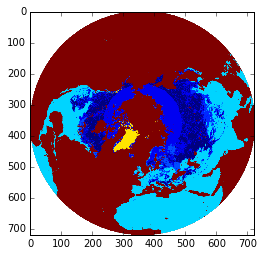

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(msce[0, :, :])

Looking down on the North Pole, we can recognize familiar geographic shapes: North America to the left, Asia to the right, and Greenland in yellow near the center. Note that the scale of the axes are in rows and columns, not latitudes and longitudes. Still, this is a helpful visual verification that we are looking at reasonable data.

Let's use NumPy to convert our `msce` variable into an `ndarray` object, and get rid of that useless first dimension. NumPy's `squeeze` method removes all trivial (one-element) dimensions from a multidimensional array.

In [33]:
import numpy as np
msce = np.squeeze(msce)
msce.shape

(720, 720)

That's better. Now `msce`'s dimension matches that of `latitude` and `longitude`.

How much _good_ data do we have in `msce`? That is, how many data elements are there in total, and how many are set to the bad-data fill value?

In [34]:
print(msce.size)
print(msce[msce != -99].size)

518400
408052


# Paul: Is this what you want to say?

So, over 20% of the data elements are set to the fill value. This sometimes happens with satellite (and other data): Quality Control (QC) algorithms determine that some observations are suspect, so they are marked as such so that further analysis can avoid depending on them.

Looking at areas where the images is missing you can see that it has been marked as missing in off earth positions.

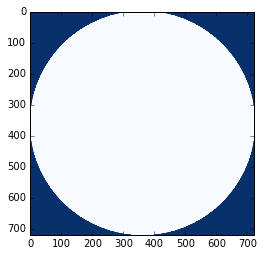

In [35]:
plt.imshow(msce == -99, cmap="Blues")

### Subsetting data with OpenDAP

One benefit to using OpenDAP for data acess is that data can be subsetted prior to download, to avoid the transfer and storage of data one is not interested in.

NSIDC's [OPeNDAP Server Dataset Access Form](http://opendap.apps.nsidc.org/opendap/DATASETS/nsidc0530_MEASURES_nhsnow_daily25/2012/nhtsd25e2_20120101_v01r01.nc.html) for this data gives some guidance on subsetting the data. For starters, let's restrict our query to the three variables -- Latitude, Longitude, and Merged Snow Cover Extent -- that we are interested in. When we tick the checkboxes for _latitude_, _longitude_, and _merged_snow_cover_extent_, the URL shown in the _Data URL_ field is updated to:

`http://opendap.apps.nsidc.org:80/opendap/DATASETS/nsidc0530_MEASURES_nhsnow_daily25/2012/nhtsd25e2_20120101_v01r01.nc?latitude[0:1:719][0:1:719],longitude[0:1:719][0:1:719],merged_snow_cover_extent[0:1:0][0:1:719][0:1:719]`

Let's perform our query and data again with this URL and check the variables we have now:

In [36]:
url = ('http://opendap.apps.nsidc.org:80/opendap/DATASETS/'
       'nsidc0530_MEASURES_nhsnow_daily25/2012/nhtsd25e2_20120101_v01r01.nc?'
       'latitude[0:1:719][0:1:719],'
       'longitude[0:1:719][0:1:719],'
       'merged_snow_cover_extent[0:1:0][0:1:719][0:1:719]'
)
dataset = netCDF4.Dataset(url)
for variable in dataset.variables:
    print(variable)

latitude
longitude
merged_snow_cover_extent


Previously, we had ten variables; now we have only three. Nice.

Let's say we're only interested in snow cover in Iceland. Let's subset the data geographically as well. The [OPeNDAP Server Dataset Access Form](http://opendap.apps.nsidc.org/opendap/DATASETS/nsidc0530_MEASURES_nhsnow_daily25/2012/nhtsd25e2_20120101_v01r01.nc.html) gives us options for constraining the variables, but expects us to do so by row and column. Iceland lies between about 12 to 25 degrees west, and 63 to 67 degrees north. Let's see which rows and columns in our Dataset fall within those bounds:

In [37]:
# Matt
latitude = np.array(dataset.variables['latitude'])
longitude = np.array(dataset.variables['longitude'])
minrow = 720
maxrow = -1
mincol = 720
maxcol = -1
for row in range(0, 720):
    for col in range(0, 720):
        a = latitude[row][col]
        b = longitude[row][col]
        if a >= 63 and a <= 67 and b >= -25 and b <= -12:
            minrow = min(minrow, row)
            maxrow = max(maxrow, row)
            mincol = min(mincol, col)
            maxcol = max(maxcol, col)
print('rows %d:%d' % (minrow, maxrow))
print('cols %d:%d' % (mincol, maxcol))

rows 453:476
cols 310:338


Create a boolean array of values that surround iceland.

In [38]:
in_range = (latitude >= 63) & (latitude <= 67) & (longitude >= -25) & (longitude <= -12)

Get a tuple of (x, y) locations on `in_range` where `in_range` is true

In [39]:
y, x = np.where(in_range)
print(in_range[y[0:5], x[0:5]])

[ True  True  True  True  True]


In [40]:
bbox = np.min(y), np.max(y), np.min(x), np.max(x)
print(bbox)


(453, 476, 310, 338)


Now let's add contraints our OpenDAP URL to select just the rows and columns that we think correspond to Iceland. The OpenDAP constraints are given in `lower_bound:stride:upper_bound` form:

In [41]:
url = ('http://opendap.apps.nsidc.org:80/opendap/DATASETS/'
       'nsidc0530_MEASURES_nhsnow_daily25/2012/nhtsd25e2_20120101_v01r01.nc?'
       'latitude[453:1:476][310:1:338],'
       'longitude[453:1:476][310:1:338],'
       'merged_snow_cover_extent[0:1:0][453:1:476][310:1:338]'
)
dataset = netCDF4.Dataset(url)
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary: CF Standard Name Table (v22, 12 February 2013)
    id: nhtsd25e2_20120101_v01r01.nc
    naming_authority: gov.nasa.eosdis
    reference: http://dx.doi.org/10.5067/MEASURES/CRYOSPHERE/nsidc-0530.001
    metadata_link: http://nsidc.org/api/metadata?id=nsidc-0530
    title: MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Daily 25km EASE-Grid 2.0
    product_version: v01r01
    summary: This NASA MEaSUREs Earth System Data Record (ESDR) merges daily Northern Hemisphere snow cover extents over land derived from three independently produced sources.  Variables include snow cover extent from the Interactive Multisensor Snow and Ice Mapping System (IMS), a gap-filled snow extent product derived from the Moderate Resolution Imaging Spectroradiometer (MODIS), and a 

Note the line `dimensions(sizes): time(1), cols(29), rows(24)`: 24 rows and 29 columns, which corresponds to our request. This is a lot less data than we were getting with the full 720 x 720 grids!

In Module 3, we'll display this geolocated data and see if we really got what we asked for.